# Bayesian Inference for Gaussian Hidden Markov Model (CMAR)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import digamma, logsumexp, gammaln
from scipy.stats import wishart

cmap = plt.get_cmap("tab10")
output_path = './output/'

## Synthesize data

In [2]:
N = 500 # number of samples
D = 1 # number of dimensions
K = 2 # number of clusters

# hyper-parameters of mu, mean & beta(scale)
m_model = np.zeros((D,K))
b_model = np.ones(K)
# hyper-parameters of Lambda, nu & W
nu_model = (D+1) * np.ones(K)
W_model = np.zeros((D,D,K))
for k in range(K):
    W_model[:,:,k] = 2.0 * np.eye(D) + 0.1 * np.ones((D,D))

# hyper-parameters of phi, alpha
alpha_model = 10.0 * np.ones(K)
# hyper-paramters of A, beta
beta_model = 50.0 * np.eye(K) + 1.0 * np.ones((K,K))

In [3]:
# parameter of X, mu_true & Lambda_true
Lam_true = np.zeros((D,D,K))
for k in range(K):
    tmp_wishart = wishart(df=nu_model[k], scale=W_model[:,:,k])
    Lam_true[:,:,k] = tmp_wishart.rvs(1)
mu_true = np.zeros((D,K))
for k in range(K):
    mu_true[:,k] = np.random.multivariate_normal(mean=m_model[:,k], cov=np.linalg.inv(b_model[k]*Lam_true[:,:,k]))

# initial probability, phi_true
phi_true = np.random.dirichlet(alpha=alpha_model)
# transitional probability, A_true
A_true = np.zeros((K,K))
for i in range(K):
    A_true[:,i] = np.random.dirichlet(alpha=beta_model[:,i])

# complete latent variable, S_true
S_true = np.zeros((K,N))
for n in range(N):
    if n == 0:
        S_true[:,n] = np.random.multinomial(n=1, pvals=phi_true)
    else:
        s = np.argmax(S_true[:,n-1])
        S_true[:,n] = np.random.multinomial(n=1, pvals=A_true[:,s])

# complete data, X_true
X_true = np.zeros((D,N))
for n in range(N):
    s = np.argmax(S_true[:,n])
    X_true[:,n] = np.random.multivariate_normal(mean=mu_true[:,s], cov=np.linalg.inv(Lam_true[:,:,s]))

# Mask
mr = 0.2 # missing rate
mask = np.random.binomial(n=1, p=1.0-mr, size=X_true.shape) < 1

# observed data X
X_obs = np.copy(X_true)
X_obs[mask] = np.nan

# latent variable, only observed data
S_obs = np.copy(S_true)
S_obs[np.array([mask[0]]*K)] = np.nan

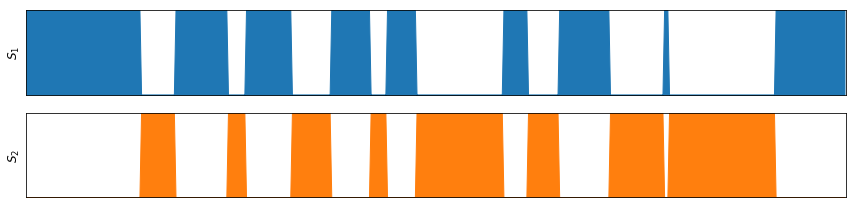

In [4]:
plt.figure(figsize=(12,1.5*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), S_true[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$S_%i$'%(k+1), fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'S_true.png', bbox_inches='tight')

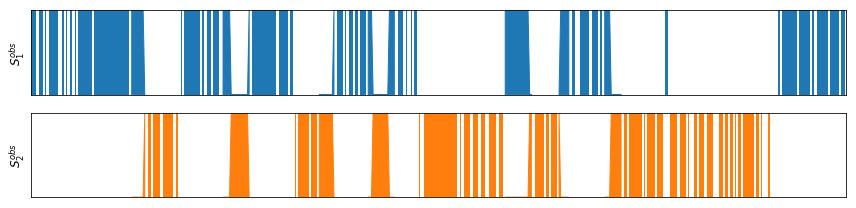

In [5]:
plt.figure(figsize=(12,1.5*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), S_obs[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$S_%i^{obs}$'%(k+1), fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'S_obs.png', bbox_inches='tight')

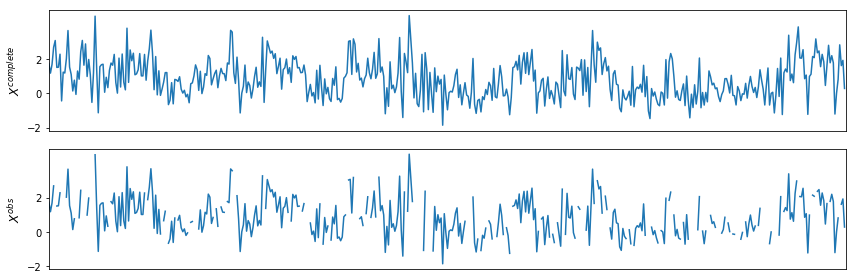

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1, xlim=(0,500), xticks=[], yticks=[-2,0,2])
plt.plot(np.arange(N), X_true[0,:])
plt.ylabel(r'$X^{complete}$', fontsize=12)
plt.subplot(2,1,2, xlim=(0,500), xticks=[], yticks=[-2,0,2])
plt.plot(np.arange(N), X_obs[0,:])
plt.ylabel(r'$X^{obs}$', fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'X_comp_obs.png', bbox_inches='tight')

In [ ]:
# plot 2D data
'''
mode = np.argmax(S_true, 0)
mode_idx = []
for k in range(K):
    mode_idx.append(np.where(mode==k)[0])

plt.figure(figsize=(4,4))
for k in range(K):
    idx = mode_idx[k]
    plt.scatter(X_true[0,idx],X_true[1,idx], alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.tight_layout()
'''

In [ ]:
# plot 2D data
'''
mode = np.argmax(S_true, 0)
mode_idx = []
for k in range(K):
    mode_idx.append(np.where(mode==k)[0])

plt.figure(figsize=(4,4))
for k in range(K):
    idx = mode_idx[k]
    plt.scatter(X_obs[0,idx],X_obs[1,idx], alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.tight_layout()
'''

## Algorithm

In [8]:
def sumdigamma(nu, D):
    ret = 0.0
    for d in range(1,D+1):
        ret += digamma(0.5*(nu + 1 - d))
    return ret

In [9]:
def update_Z(X, Z, parameters):
    (K, N) = Z.shape
    D = len(X)
    expt_mu, b_post, nu_post, W_post, alpha_post, beta_post = parameters
    
    ln_lkh = np.zeros((K,N))
    for k in range(K):
        mu = expt_mu[:,k]
        expt_Lam = nu_post[k] * W_post[:,:,k]
        expt_ln_Lam = sumdigamma(nu_post[k], D) + D * np.log(2) + np.linalg.slogdet(W_post[:,:,k])[1]
        expt_Lam_mu = nu_post[k] * np.dot(W_post[:,:,k], mu[:,None])
        expt_mu_Lam_mu = nu_post[k] * np.dot(mu[None,:], np.dot(W_post[:,:,k], mu[:,None])) + D / b_post[k]
        for n in range(N):
            x = X[:,n]
            ln_lkh[k,n] = - 0.5 * ( np.dot(x[None,:], np.dot(expt_Lam, x[:,None])) 
                                   + expt_mu_Lam_mu 
                                   - 2 * np.dot(x[None,:], expt_Lam_mu) 
                                   - expt_ln_Lam )
    
    expt_ln_phi = digamma(alpha_post) - digamma(np.sum(alpha_post))
    
    expt_ln_A = np.zeros((K,K))
    for i in range(K):
        expt_ln_A[:,i] = digamma(beta_post[:,i]) - digamma(np.sum(beta_post[:,i]))
    
    ln_expt_Z = np.log(Z+1e-10)
    # n = 0
    ln_expt_Z[:,0] = ln_lkh[:,0] + expt_ln_phi + np.dot(expt_ln_A.T, np.exp(ln_expt_Z[:,1]))
    ln_expt_Z[:,0] -= logsumexp(ln_expt_Z[:,0])
    
    # 0 < n < N-1
    for n in range(1,N-1):
        ln_expt_Z[:,n] = ln_lkh[:,n] + np.dot(expt_ln_A, np.exp(ln_expt_Z[:,n-1])) + np.dot(expt_ln_A.T, np.exp(ln_expt_Z[:,n+1]))
        ln_expt_Z[:,n] -= logsumexp(ln_expt_Z[:,n])
    
    # n = N-1
    ln_expt_Z[:,N-1] = ln_lkh[:,N-1] + np.dot(expt_ln_A, np.exp(ln_expt_Z[:,N-1]))
    ln_expt_Z[:,N-1] -= logsumexp(ln_expt_Z[:,N-1])
    
    expt_Z = np.exp(ln_expt_Z)
    
    expt_ZZ = np.zeros((K,K,N))
    for n in range(N-1):
        for j in range(K):
            for i in range(K):
                expt_ZZ[j,i,n+1] = expt_Z[j,n+1] * expt_Z[i,n]
    
    return expt_Z, expt_ZZ

In [10]:
def update_parameters(prior, X, Z, ZZ):
    (K, N) = Z.shape
    D = len(X)
    mu_pri, b_pri, nu_pri, W_pri, alpha_pri, beta_pri = prior
    sum_Z = np.sum(Z, 1)
    sum_ZZ = np.sum(ZZ, 2)
    
    alpha_post = Z[:,0] + alpha_pri
    beta_post = sum_ZZ + beta_pri
    
    b_post = sum_Z + b_pri
    ZX = np.dot(X, Z.T)
    nu_post = sum_Z + nu_pri
    
    expt_mu = np.zeros((D,K))
    W_post = np.zeros((D,D,K))
    for k in range(K):
        m = mu_pri[:,k]
        m_post = (ZX[:,k] + b_pri[k]*m) / b_post[k]
        expt_mu[:,k] = m_post
        W_post[:,:,k] = np.linalg.inv(np.dot(X, np.dot(np.diag(Z[k,:]), X.T)) 
                                      + b_pri[k]*np.dot(m[:,None], m[None,:]) 
                                      - b_post[k]*np.dot(m_post[:,None], m_post[None,:]) 
                                      + np.linalg.inv(W_pri[:,:,k]))
    
    return expt_mu, b_post, nu_post, W_post, alpha_post, beta_post

In [11]:
def interpolate(mask, expt_Z, expt_mu, nu_post, W_post):
    (K, N) = expt_Z.shape
    D = len(mask)
    
    X_est = np.zeros((D,N))
    Lam_est = np.zeros((D,D,N))
    for n in range(N):
        tilde_Lam = np.zeros((D,D))
        tilde_Lam_mu = np.zeros(D)
        for k in range(K):
            z = expt_Z[k,n]
            expt_Lam = nu_post[k] * W_post[:,:,k]
            expt_Lam_mu = nu_post[k] * np.dot(W_post[:,:,k], expt_mu[:,k])
            tilde_Lam += z * expt_Lam
            tilde_Lam_mu += z * expt_Lam_mu
        tilde_mu = np.dot(np.linalg.inv(tilde_Lam), tilde_Lam_mu)
        X_est[:,n] = tilde_mu
        Lam_est[:,:,n] = tilde_Lam
    return X_est[mask], Lam_est

In [12]:
def sumgammaln(nu, D):
    ret = 0.0
    for d in range(1, D+1):
        ret += gammaln(0.5*(nu + 1 - d))
    return ret

In [13]:
def calc_elbo(X, Z, ZZ, prior, posterior):
    (K, N) = Z.shape
    D = len(X)
    mu_pri, b_pri, nu_pri, W_pri, alpha_pri, beta_pri = prior
    expt_mu, b_post, nu_post, W_post, alpha_post, beta_post = posterior
    
    expt_Lam = np.zeros((D,D,K))
    expt_Lam_mu = np.zeros((D,K))
    expt_mu_Lam_mu = np.zeros(K)
    expt_ln_Lam = np.zeros((K))
    for k in range(K):
        expt_Lam[:,:,k] = nu_post[k] * W_post[:,:,k]
        expt_Lam_mu[:,k] = nu_post[k] * np.dot(W_post[:,:,k], expt_mu[:,k])
        expt_mu_Lam_mu[k] = nu_post[k] * np.dot(expt_mu[:,k], np.dot(W_post[:,:,k], expt_mu[:,k])) + D / b_post[k]
        expt_ln_Lam[k] = sumdigamma(nu_post[k], D) + D * np.log(2) + np.linalg.slogdet(W_post[:,:,k])[1]
    
    expt_ln_lkh = np.zeros((K,N))
    for k in range(K):
        for n in range(N):
            x = X[:,n]
            z = Z[k,n]
            expt_ln_lkh[k,n] = - 0.5 * z * ( np.dot(x[None,:], np.dot(expt_Lam[:,:,k], x[:,None])) 
                                            + expt_mu_Lam_mu[k] - 2 * np.dot(x[None,:], expt_Lam_mu[:,k]) 
                                            - expt_ln_Lam[k] + D * np.log(2*np.pi) )
    
    expt_ln_phi = digamma(alpha_post) - digamma(np.sum(alpha_post))
    expt_ln_A = np.zeros((K,K))
    for i in range(K):
        expt_ln_A[:,i] = digamma(beta_post[:,i]) - digamma(np.sum(beta_post[:,i]))
    
    expt_ln_ps = np.zeros((1,N))
    for n in range(N):
        if n == 0:
            expt_ln_ps[:,n] = np.dot(Z[:,0], expt_ln_phi)
        else:
            expt_ln_ps[:,n] = np.sum( ZZ[:,:,n] * expt_ln_A)
    
    expt_ln_qs = np.sum( Z * np.log(Z + 1e-10))
    
    kl_mu = np.zeros((1,K))
    for k in range(K):
        kl_mu[:,k] = ( (b_post[k] - b_pri[k]) * expt_mu_Lam_mu[k] 
                    - 2 * np.dot((b_post[k]*expt_mu[:,k] - b_pri[k]*mu_pri[:,k]), expt_Lam_mu[:,k]) 
                    + b_post[k] * np.dot(expt_mu[:,k], np.dot(expt_Lam[:,:,k], expt_mu[:,k])) 
                    - b_pri[k] * np.dot(mu_pri[:,k], np.dot(expt_Lam[:,:,k], mu_pri[:,k])) 
                    - np.log(b_post[k]) + np.log(b_pri[k]) )
    
    kl_Lam = np.zeros((1,K))
    for k in range(K):
        kl_Lam[:,k] = ( 0.5 * (nu_post[k] - nu_pri[k]) * expt_ln_Lam[k] 
                     - 0.5 * np.trace(np.dot(np.linalg.inv(W_post[:,:,k]) 
                                             - np.linalg.inv(W_pri[:,:,k]), 
                                             expt_Lam[:,:,k])) 
                     - 0.5 * nu_post[k] * np.linalg.slogdet(W_post[:,:,k])[1] 
                     + 0.5 * nu_pri[k] * np.linalg.slogdet(W_pri[:,:,k])[1] 
                     - sumgammaln(nu_post[k], D) 
                     + sumgammaln(nu_pri[k], D) 
                     - 0.5 * D * (nu_post[k] - nu_pri[k]) )
    
    kl_phi = ( np.dot(alpha_post- alpha_pri, expt_ln_phi) 
              + gammaln(np.sum(alpha_post)) - np.sum(gammaln(alpha_post)) 
              - gammaln(np.sum(alpha_pri)) + np.sum(gammaln(alpha_pri)) )
    
    kl_A = ( np.sum((beta_post - beta_pri) * expt_ln_A) 
            + np.sum(gammaln(np.sum(beta_post, 0))) - np.sum(gammaln(beta_post)) 
            - np.sum(gammaln(np.sum(beta_pri, 0))) + np.sum(gammaln(beta_pri)) )
    
    VB = np.sum(expt_ln_lkh) + np.sum(expt_ln_ps) - expt_ln_qs - np.sum(kl_mu) -np.sum(kl_Lam) - kl_phi - kl_A
    return VB

## Set prior distribution

In [14]:
(D, N) = X_obs.shape
K = 2

# mean_prior & beta_prior(scale)
m_init = np.zeros((D,K))
b_init = np.ones(K)
# nu_prior, W_prior
nu_init = D * np.ones(K)
W_init = np.zeros((D,D,K))
for k in range(K):
    W_init[:,:,k] = 1.0 * np.eye(D) + 0.0 * np.ones((D,D))

# alpha_prior
alpha_init = 10.0 * np.ones(K)
# beta_prior
beta_init = 100.0 * np.eye(K) + 1.0 * np.ones((K,K))

## Initialize variables & parameters

In [15]:
# initialisation
phi = np.random.dirichlet(alpha=alpha_init)
A = np.zeros((K,K))
for i in range(K):
    A[:,i] = np.random.dirichlet(alpha=beta_init[:,i])

Z = np.zeros((K,N))
for n in range(N):
    Z[:,n] = np.random.dirichlet(np.ones(K)/K, 1)

ZZ = np.zeros((K,K,N))
for n in range(N-1):
    for j in range(K):
        for i in range(K):
            ZZ[j,i,n+1] = Z[j,n+1] * Z[i,n]

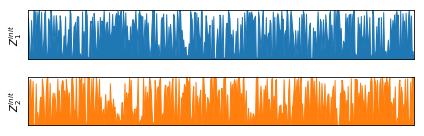

In [16]:
plt.figure(figsize=(6,1*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), Z[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$Z_%i^{init}$'%(k+1))
plt.tight_layout()

## Train: estimation & interpolation

In [17]:
# initial geuss
mu_guess = np.mean(X_obs[~mask].reshape(D,-1), 1, keepdims=True)
sig_guess = np.std(X_obs[~mask].reshape(D,-1), 1, keepdims=True)
X_guess = np.zeros((D,N))
for n in range(N):
    X_guess[:,n] = np.random.multivariate_normal(mean=mu_guess[:,0], cov=np.square(sig_guess))

In [18]:
# train
expt_Z = np.copy(Z)
expt_ZZ = np.copy(ZZ)

max_iter = 100

elbo = np.zeros(max_iter)
#X_tmp = np.copy(X_true)
X_tmp = np.copy(X_obs)
X_tmp[mask] = X_guess[mask]
tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta = update_parameters([m_init, b_init, nu_init, W_init, alpha_init, beta_init], 
                                                                      X_tmp, expt_Z, expt_ZZ)
for i in range(max_iter):
    if np.sum(mask) > 0:
        X_tmp[mask], Lam_est = interpolate(mask, expt_Z, tmp_mu, tmp_nu, tmp_W)
    expt_Z, expt_ZZ = update_Z(X_tmp, expt_Z, [tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta])
    tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta = update_parameters([m_init, b_init, nu_init, W_init, alpha_init, beta_init], 
                                                                X_tmp, expt_Z, expt_ZZ)
    elbo[i] = calc_elbo(X_tmp, expt_Z, expt_ZZ, [m_init, b_init, nu_init, W_init, alpha_init, beta_init], 
                   [tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta])

In [19]:
std_est = np.zeros((D,N))
for d in range(D):
    std_est[d,mask[d]] = np.sqrt(1/Lam_est[d,d,:])[mask[d]]

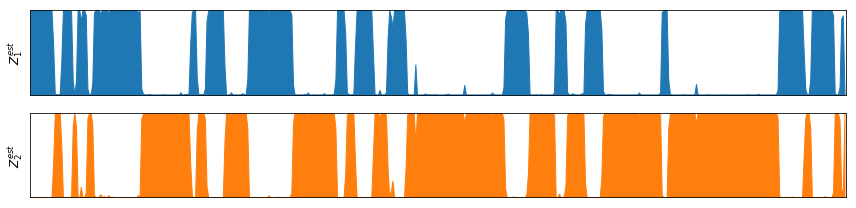

In [20]:
plt.figure(figsize=(12,1.5*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), expt_Z[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$Z_%i^{est}$'%(k+1), fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'S_est.png', bbox_inches='tight')

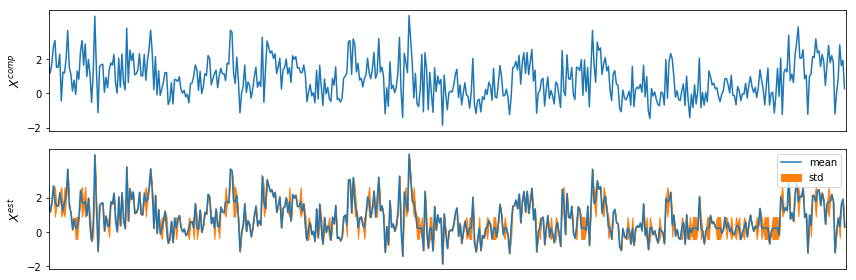

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1, xlim=(0,500), xticks=[], yticks=[-2,0,2])
plt.plot(np.arange(N), X_true[0,:])
plt.ylabel(r'$X^{comp}$', fontsize=12)
plt.subplot(2,1,2, xlim=(0,500), xticks=[], yticks=[-2,0,2])
plt.plot(np.arange(N), X_tmp[0,:], label='mean')
plt.fill_between(np.arange(N), X_tmp[0,:]+std_est[0,:], X_tmp[0,:]-std_est[0,:], color=cmap(1), alpha=1.0, label='std')
plt.ylabel(r'$X^{est}$', fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig(output_path + 'X_comp_est.png', bbox_inches='tight')

In [ ]:
# plot 2D data
'''
mode = np.argmax(expt_Z, 0)
mode_idx = []
for k in range(K):
    mode_idx.append(np.where(mode==k)[0])

plt.figure(figsize=(4,4))
for k in range(K):
    idx = mode_idx[k]
    plt.scatter(X_tmp[0,idx], X_tmp[1,idx], alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.tight_layout()
'''

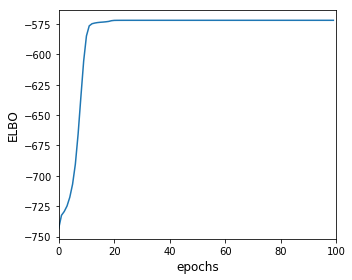

In [24]:
# plot elbo
plt.figure(figsize=(5,4))
plt.plot(elbo)
plt.xlim(0, max_iter)
plt.xlabel('epochs', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'elbo.png', bbox_inches='tight')

## Train using complete data

In [25]:
# initialisation
phi = np.random.dirichlet(alpha=alpha_init)
A = np.zeros((K,K))
for i in range(K):
    A[:,i] = np.random.dirichlet(alpha=beta_init[:,i])

Z = np.zeros((K,N))
for n in range(N):
    Z[:,n] = np.random.dirichlet(np.ones(K)/K, 1)

ZZ = np.zeros((K,K,N))
for n in range(N-1):
    for j in range(K):
        for i in range(K):
            ZZ[j,i,n+1] = Z[j,n+1] * Z[i,n]

# train
expt_Z = np.copy(Z)
expt_ZZ = np.copy(ZZ)

max_iter = 100
elbo = np.zeros(max_iter)
for i in range(max_iter):
    expt_Z, expt_ZZ = update_Z(X_true, expt_Z, [tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta])
    tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta = update_parameters([m_init, b_init, nu_init, W_init, alpha_init, beta_init], 
                                                                X_true, expt_Z, expt_ZZ)
    elbo[i] = calc_elbo(X_true, expt_Z, expt_ZZ, [m_init, b_init, nu_init, W_init, alpha_init, beta_init], 
                   [tmp_mu, tmp_b, tmp_nu, tmp_W, tmp_alpha, tmp_beta])

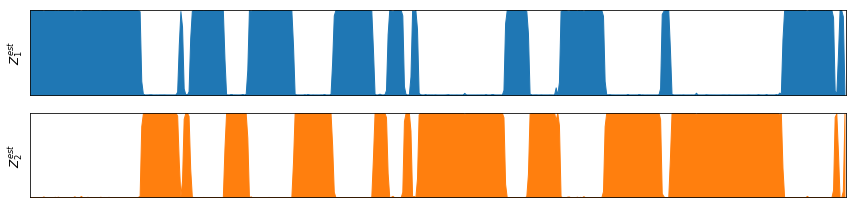

In [26]:
plt.figure(figsize=(12,1.5*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), expt_Z[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$Z_%i^{est}$'%(k+1), fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'S_est.png', bbox_inches='tight')

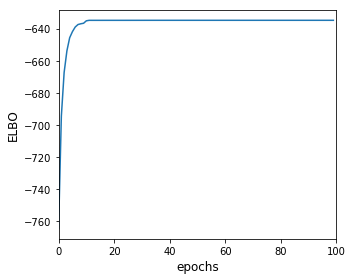

In [27]:
# plot elbo
plt.figure(figsize=(5,4))
plt.plot(elbo)
plt.xlim(0, max_iter)
plt.xlabel('epochs', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.tight_layout()
#plt.savefig(output_path + 'elbo.png', bbox_inches='tight')